In [ ]:
import sys
!{sys.executable} -m pip install sklearn --user

In [1]:
# Adds SIFT and SURF functionalities.
import sys
sys.path.append("/usr/local/lib/python3.8/site-packages/")

In [2]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as lin

In [3]:
import utils        # Utility to measure code execution
                    # and plot confusion matrices.
import vocabulary   # Read images and produce visual vocabulary.
import classifiers  # Implements different classifiers.

In [ ]:
# Reload modules without reloading the kernel.
import importlib
importlib.reload(utils)

---

# Main

## 1. and 2.: reading images, computing visual words and histograms

In [4]:
train_path = "../dataset/train"
test_path = "../dataset/test"

n_clusters = 96 # Size of dictionary.
n_descriptors = 100000

In [5]:
with utils.codeTimer("Build train set"):
    
    # Read images and compute descriptors, saving them in a dataframe.
    train_df = vocabulary.compute_descriptors(train_path)
    
    print("Total number of {}-dimensional descriptors: {}"
          .format(len(train_df['descriptor'][0]), len(train_df)))

    # Compute kmeans clustering using descriptors to obtain visual dictionary.

    # Note: cluster centers are stored in this object,
    # and can be obtained using `kmeans.cluster_centers_`.
    kmeans = vocabulary.k_means_words(train_df, n_clusters, n_descriptors)
    
    # Aggregate descriptor info, making dataframe more compact.
    # Now the third column contains the list of descriptors.
    train_df = train_df.groupby(['image_id', 'label'],
                                as_index = False).agg({'descriptor':
                                                       (lambda x: list(x))})

    # Compute histograms and add them to dataframe.
    train_histograms = vocabulary.compute_histogram(train_df, kmeans)
    train_df['histogram'] = train_histograms

Total number of 128-dimensional descriptors: 762342
Number of sampled descriptors: 100000
Clustered the descriptors in 96 clusters
Executed 'Build train set'.  Elapsed time: 998.463808s


In [6]:
# Perform analogous operations to compute histograms for test set,
# using words extracted from train.

with utils.codeTimer("Build test set"):

    test_df = vocabulary.compute_descriptors(test_path)

    test_df = test_df.groupby(['image_id', 'label'],
                                as_index = False).agg({'descriptor':
                                                       (lambda x: list(x))})

    # Note, kmeans has not been recomputed, the training one is used.
    test_histograms = vocabulary.compute_histogram(test_df, kmeans)
    test_df['histogram'] = test_histograms

Executed 'Build test set'.  Elapsed time: 1384.557309s


----

## 3.: Nearest Neighbor classifier

In [7]:
with utils.codeTimer("NN classifier"):
    true, predicted = classifiers.nn_classifier(train_df, test_df)
    
# Adding predicted lables to dataframe.
test_df["predicted"] = predicted

Executed 'NN classifier'.  Elapsed time: 1002.027148s


Accuracy: 0.16437290507676985


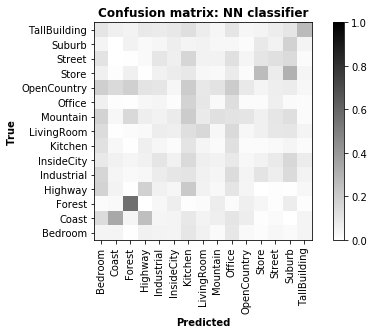

In [8]:
utils.plot_confusion_matrix(true, predicted,
                            title = "Confusion matrix: NN classifier",
                            filename = "nn.pdf")

----

## 4. and 5.: linear SVM

In [11]:
with utils.codeTimer("Linear SVM classifier"):
    true, predicted = classifiers.linear_SVM_classifier(train_df, test_df)
    
# Adding predicted lables to dataframe.
test_df["predicted"] = predicted

Executed 'Linear SVM classifier'.  Elapsed time: 32.694481s


Accuracy: 0.39285455205451525


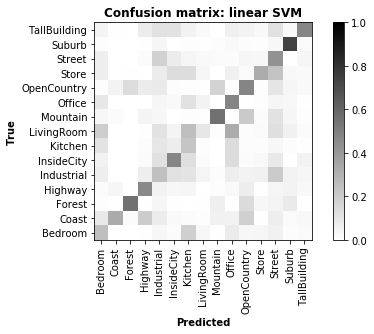

In [12]:
#importlib.reload(utils)
utils.plot_confusion_matrix(true, predicted,
                            title = "Confusion matrix: linear SVM",
                            filename = "linsvm.pdf")

----

## 6. and 7.: Gaussian SVM

In [22]:
with utils.codeTimer("Gaussian SVM classifier, chi squared distance"):
    true, predicted = classifiers.gaussian_SVM_classifier(train_df, test_df,
                                                          dist = 'chi')
    
# Adding predicted lables to dataframe.
test_df["predicted"] = predicted

Executed 'Gaussian SVM classifier, chi squared distance'.  Elapsed time: 969.631036s


Accuracy: 0.4259883772897459


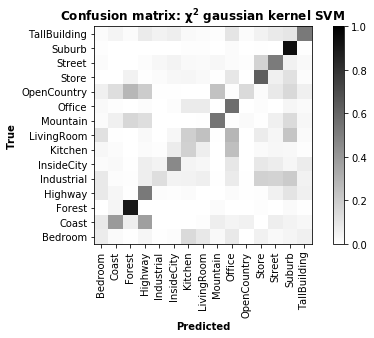

In [23]:
utils.plot_confusion_matrix(true, predicted,
                            title = r"Confusion matrix: $\mathbf{\chi^2}$ gaussian kernel SVM",
                            filename = "gaussvm.pdf")

In [15]:
with utils.codeTimer("Gaussian SVM classifier, earth mover distance"):
    true, predicted = classifiers.gaussian_SVM_classifier(train_df, test_df,
                                                          dist = 'emd')
    
# Adding predicted lables to dataframe.
test_df["predicted"] = predicted

Executed 'Gaussian SVM classifier, earth mover distance'.  Elapsed time: 423.679656s


Accuracy: 0.21899035191759667


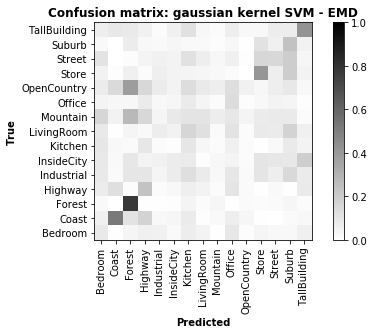

In [16]:
utils.plot_confusion_matrix(true, predicted,
                            title = "Confusion matrix: gaussian kernel SVM - EMD")

----

## 8.: Error Correcting Output Code

In [17]:
with utils.codeTimer("ECOC SVM classifier"):
    true, predicted = classifiers.ecoc_classifier(train_df, test_df,
                                                  n_classifiers = 100)
    
# Adding predicted lables to dataframe.
test_df["predicted"] = predicted

Executed 'ECOC SVM classifier'.  Elapsed time: 126.166038s


Accuracy: 0.4807206484860783


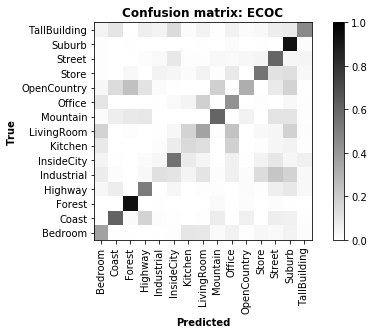

In [18]:
utils.plot_confusion_matrix(true, predicted,
                            title = "Confusion matrix: ECOC",
                            filename = "ecoc.pdf")

----